## Loading libraries

In [1]:
# general packages for data manipulation
import sklearn 
import numpy as np
import pandas as pd

# visualizations
import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# consistent size plots
from pylab import rcParams
rcParams['figure.figsize']=12,5
rcParams['axes.labelsize']=12
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=12

# handle warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

# display pandas dataframe columns 
pd.options.display.max_columns = None


# Load the sklearn stuff
import sklearn 
print(sklearn.__version__)

# making text data numeric
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# making numeric data comparable
from sklearn.preprocessing import StandardScaler

# experimental regime and pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# machine learning algorithm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# get reproducible results
np.random.seed(42)
#tf.random.set_seed(42)

1.0.2


## Data inspection

In [2]:
data_path = 'OLIDv1.0_sharedtask/olid-training-v1.0.tsv'
OLID_train = pd.read_csv(data_path, delimiter='\t', encoding='utf-8')
OLID_train.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [3]:
OLID_train.rename({'tweet': 'text', 'subtask_a': 'label'}, axis=1, inplace=True) # rename columns if necessary
OLID_train['target'] = OLID_train.label.map({'NOT':0, 'OFF':1}) # convert label to a numerical variable
OLID_train.drop(['subtask_b', 'subtask_c'], axis=1, inplace=True) # drop irrelevant columns
OLID_train.head()

# create a copy of the original data to work with 
df = OLID_train.copy()
df.head()

,id,text,label,target
0,86426,@USER She should ask a few native Americans wh...,OFF,1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1
2,16820,Amazon is investigating Chinese employees who ...,NOT,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0


In [4]:
# check for missing values
df.isnull().sum()

id        0
text      0
label     0
target    0
dtype: int64

In [5]:
# check for duplicates
df.duplicated().sum()

0

In [6]:
# check distributions --> Note data imbalance of 2:1 for the negative class, i.e., NOT (0)
df_Stat=df[['label','text']].groupby('label').count().reset_index()
df_Stat.columns=['label','count']
df_Stat['percentage']=(df_Stat['count']/df_Stat['count'].sum())*100
df_Stat

,label,count,percentage
0,NOT,8840,66.767372
1,OFF,4400,33.232628


## Data preprocessing/cleaning

In [7]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

nltk.download('stopwords')
eng_stops = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

def clean(text):
    # remove all the special characters
    text = re.sub('[^a-zA-Z]', ' ',text) 
    # convert all letters to lower case
    words = text.lower().split()
    # remove stop words
    words = [w for w in words if not w in eng_stops]    
    # lemmatize all words
    words = [lemmatizer.lemmatize(word) for word in words]
    # join all words back to text
    return (' '.join(words))

df['clean'] = df['text'].apply(lambda x: clean(x))
df.head()

# Note: feature extraction is performed BEFORE preprocessing, as this gave significantly results than cleaned data
# Preprocessed data will only be used when tfidf-vectorizing text data (see below), except for the neural model...

[nltk_data] Downloading package stopwords to /Users/Aron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Aron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,text,label,target,clean
0,86426,@USER She should ask a few native Americans wh...,OFF,1,user ask native american take
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,user user go home drunk user maga trump url
2,16820,Amazon is investigating Chinese employees who ...,NOT,0,amazon investigating chinese employee selling ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1,user someone vetaken piece shit volcano
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0,user user obama wanted liberal amp illegals mo...


## Intelligent SGD classifier baseline (no additional features)

(11916, 2) (1324, 2) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       884
           1       0.73      0.47      0.58       440

    accuracy                           0.77      1324
   macro avg       0.76      0.69      0.71      1324
weighted avg       0.76      0.77      0.75      1324



,888,756,1164,554,1055,859,1205,1283,774,413,1106,344,390,680,233,1261,651,303
true,1,1,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0
pred,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0


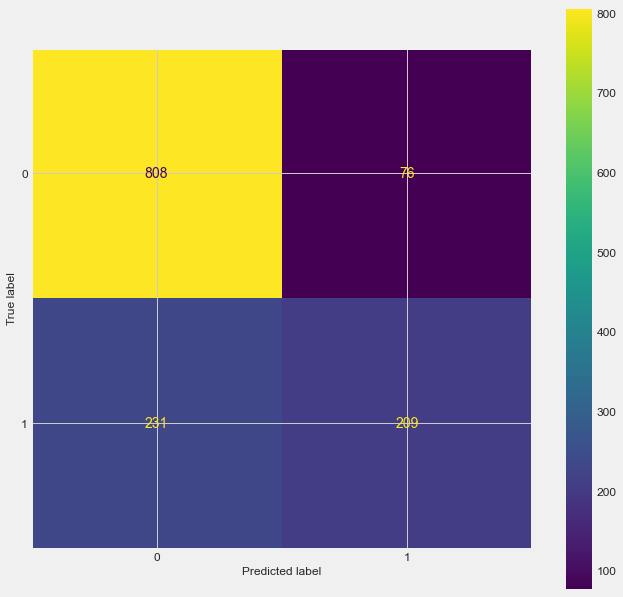

In [8]:
## SGD classifier with tf-idf weighted BoW
X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

tfidf_vect = TfidfVectorizer(max_features=5000, ngram_range=(1,2), tokenizer= str.split)

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (tfidf_vect, 'clean'),
    remainder = 'drop')

# we use an SGDClassifier
clf = SGDClassifier(random_state=42)

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train, y_train)
y_val_pred = pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_val)
preds = np.array(y_val_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       884
           1       0.73      0.47      0.58       440

    accuracy                           0.77      1324
   macro avg       0.76      0.69      0.71      1324
weighted avg       0.76      0.77      0.75      1324



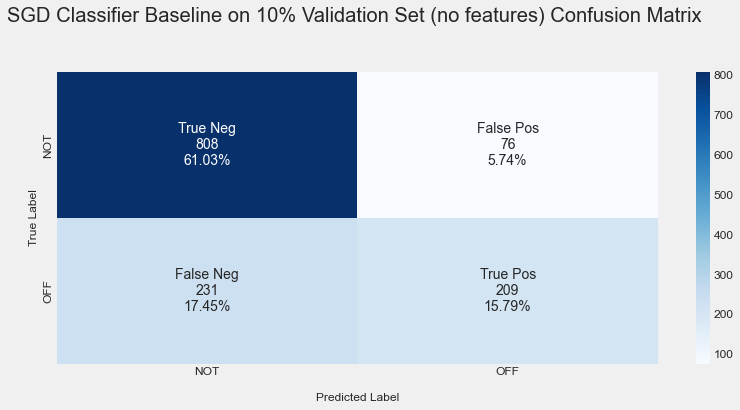

In [9]:
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('SGD Classifier Baseline on 10% Validation Set (no features) Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['NOT','OFF'])
ax.yaxis.set_ticklabels(['NOT','OFF'])

plt.savefig('SGDC_baseline_on_validation.png', bbox_inches="tight")

## Display the visualization of the Confusion Matrix.
plt.show();

In [10]:
clf.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Feature extraction/engineering (based on *unprocessed* text data)

### VADER sentiment

In [11]:
import nltk
nltk.download(['vader_lexicon'])
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['text']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['text']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['text']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['text']]
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Aron/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,id,text,label,target,clean,compound,neg,neu,pos
0,86426,@USER She should ask a few native Americans wh...,OFF,1,user ask native american take,0.0000,0.000,1.000,0.00
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,user user go home drunk user maga trump url,-0.5067,0.247,0.753,0.00
2,16820,Amazon is investigating Chinese employees who ...,NOT,0,amazon investigating chinese employee selling ...,0.3400,0.000,0.880,0.12
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1,user someone vetaken piece shit volcano,-0.5574,0.286,0.714,0.00
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0,user user obama wanted liberal amp illegals mo...,0.0000,0.000,1.000,0.00


### Profanity

In [12]:
#!pip install alt-profanity-check
#!pip install sklearn --upgrade

In [13]:
from profanity_check import predict, predict_prob

df['prof'] = predict(df['text'])
df['prof_prob'] = predict_prob(df['text'])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearSVC from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use a

In [14]:
df.head()

,id,text,label,target,clean,compound,neg,neu,pos,prof,prof_prob
0,86426,@USER She should ask a few native Americans wh...,OFF,1,user ask native american take,0.0000,0.000,1.000,0.00,0,0.044216
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,user user go home drunk user maga trump url,-0.5067,0.247,0.753,0.00,0,0.062316
2,16820,Amazon is investigating Chinese employees who ...,NOT,0,amazon investigating chinese employee selling ...,0.3400,0.000,0.880,0.12,0,0.098105
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1,user someone vetaken piece shit volcano,-0.5574,0.286,0.714,0.00,1,0.982132
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0,user user obama wanted liberal amp illegals mo...,0.0000,0.000,1.000,0.00,0,0.140452


In [15]:
# Pre-preprocessing:
df.text[1]

'@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL'

In [16]:
# Post-preprocessing:
df.clean[1]

'user user go home drunk user maga trump url'

## Experiments and model comparison (to find the best traditional model for fine-tuning)

(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       884
           1       0.64      0.65      0.65       440

    accuracy                           0.77      1324
   macro avg       0.74      0.74      0.74      1324
weighted avg       0.77      0.77      0.77      1324



,850,1212,468,589,1238,1278,807,188,900,356,1251,547,235,1083,474,1081,743,1048
true,1,0,0,1,1,1,0,0,0,0,1,0,1,1,0,1,0,1
pred,1,1,0,0,0,1,0,0,0,0,1,0,1,1,1,0,0,1


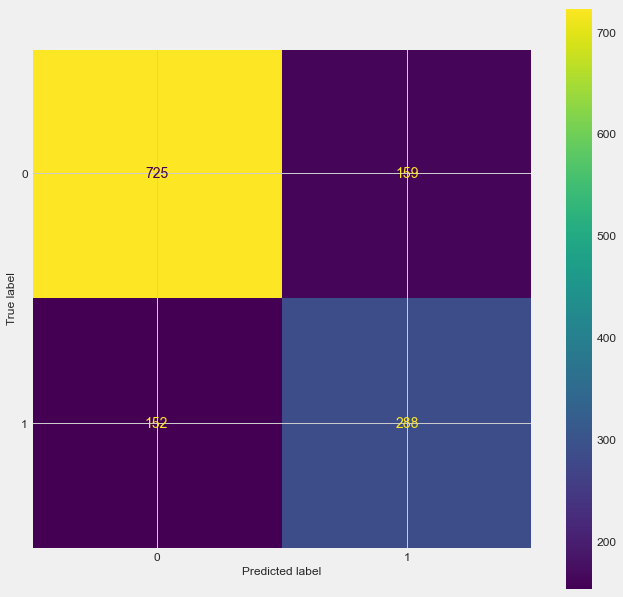

In [17]:
X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # APPLYING FEATURE EXTRACTION BEFORE CLEANING GIVES +1 macro-F1!!!
     (scaler, ['prof', 'prof_prob']),             # APPLYING FEATURE EXTRACTION BEFORE CLEANING GIVES +1 macro-F1!!!
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'), # decent results IF lemmatization disabled; otherwise, better left out (cf. count_vect)
    remainder = 'drop')


# We use an SGDClassifier
clf = SGDClassifier(random_state=42, class_weight='balanced')

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train, y_train)
y_val_pred = pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_val)
preds = np.array(y_val_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

#### 10-fold cross-validation with macro F1-score as scoring metric (on all training data)

In [18]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe, X, y, cv=10, scoring='f1_macro')
# 'f1_macro' for binary classification gives f1 for positive class
print(scores)
print('\n')
print(f"Mean {scores.mean()}, Std {scores.std()}")

# returns average macro-f1 score over 10 folds (no control over stratification, etc.) -> stratified k-fold = better
# consistent scores with small standard deviations indicate that the model is not overfitting on the train data ...

[0.71790144 0.75520474 0.75325111 0.74511267 0.72837987 0.74847095
 0.76934799 0.74735292 0.75580213 0.7443438 ]


Mean 0.7465167613968233, Std 0.013737940564124085


#### First attempt at hyper-parameter optimization using GridSearch

In [19]:
pipe.named_steps

{'columntransformer': ColumnTransformer(transformers=[('standardscaler-1', StandardScaler(),
                                  ['compound', 'neg', 'neu', 'pos']),
                                 ('standardscaler-2', StandardScaler(),
                                  ['prof', 'prof_prob']),
                                 ('tfidfvectorizer',
                                  TfidfVectorizer(ngram_range=(1, 2),
                                                  stop_words='english'),
                                  'clean')]),
 'sgdclassifier': SGDClassifier(class_weight='balanced', random_state=42)}

In [20]:
params = [{
    'columntransformer__tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (1, 4), (1, 6), (2, 7)],
    'sgdclassifier__loss': ['hinge', 'log'] # with hinge it's an svm, with log it's logistic regression
    }]

gs = GridSearchCV(pipe, params, n_jobs=-1, cv=5, verbose=1, scoring='f1_macro')
gs.fit(X, y)

# F1 = harmonic mean of precision and recall; macro = average thereof
# Note: in binary classification this only apllies to positive the class

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler-1',
                                                                         StandardScaler(),
                                                                         ['compound',
                                                                          'neg',
                                                                          'neu',
                                                                          'pos']),
                                                                        ('standardscaler-2',
                                                                         StandardScaler(),
                                                                         ['prof',
                                                                          'prof_prob']),
                                                  

In [21]:
print(gs.best_score_)  # top score
print(gs.best_params_) # best param settings -> GridSearch for hyper-parameter tuning once a model has been decided

0.7447264487549851
{'columntransformer__tfidfvectorizer__ngram_range': (1, 4), 'sgdclassifier__loss': 'hinge'}


(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       884
           1       0.64      0.65      0.64       440

    accuracy                           0.76      1324
   macro avg       0.73      0.73      0.73      1324
weighted avg       0.76      0.76      0.76      1324



,157,1168,1188,1235,1,298,84,815,988,1219,698,1215,713,772,144,1157,308,184
true,0,0,0,0,0,1,0,1,1,1,1,1,0,0,1,0,1,0
pred,0,0,0,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1


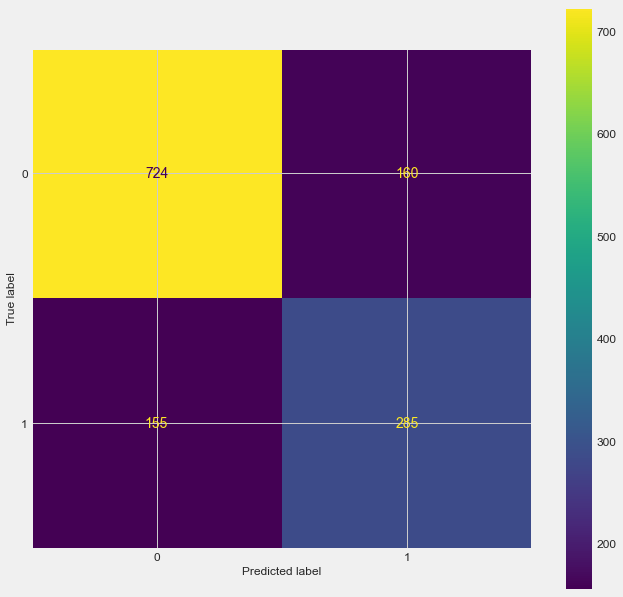

In [22]:
X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 4), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')


# We use an SGDClassifier
clf = SGDClassifier(random_state=42, class_weight='balanced', loss='hinge')

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train, y_train)
y_val_pred = pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_val)
preds = np.array(y_val_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

#### Note decrease in model performance (macro F1) after using grid-searched hyperparameters.

### Comparison with some other traditional classifiers (with added features, but no k-fold CV or grid search)

#### Logistic Regression

(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       884
           1       0.71      0.49      0.58       440

    accuracy                           0.76      1324
   macro avg       0.74      0.69      0.71      1324
weighted avg       0.75      0.76      0.75      1324



,230,785,116,439,988,1253,164,1177,698,11,133,372,606,641,1053,1296,32,722
true,0,0,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0,0
pred,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0


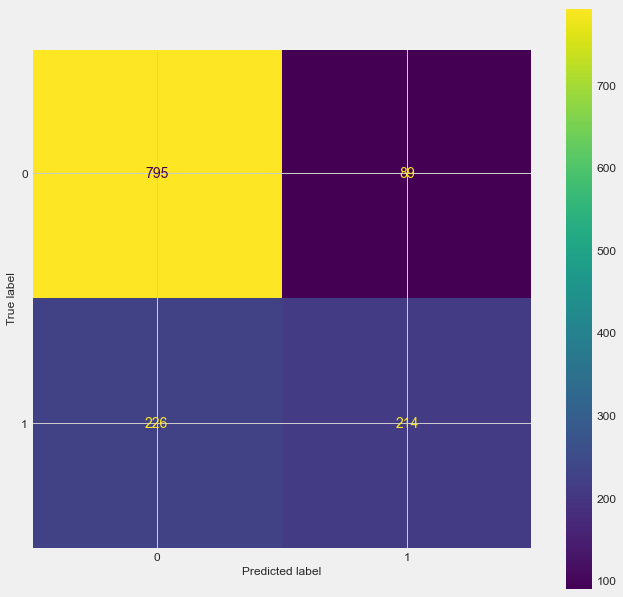

In [23]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42, max_iter=1500)

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

log_pipe = make_pipeline(preprocessor, clf)

log_pipe.fit(X_train, y_train)
y_val_pred = log_pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=log_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_val)
preds = np.array(y_val_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

#### Random Forest

(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       884
           1       0.75      0.45      0.57       440

    accuracy                           0.77      1324
   macro avg       0.76      0.69      0.71      1324
weighted avg       0.77      0.77      0.75      1324



,123,234,868,1220,355,321,487,249,1024,792,1317,10,1177,572,83,542,618,616
true,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0
pred,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0


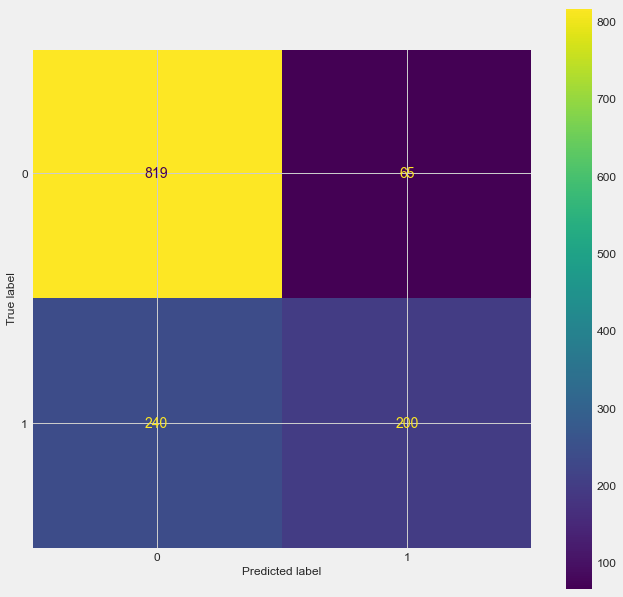

In [24]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

clf = RandomForestClassifier(random_state=42, class_weight='balanced')

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train, y_train)
y_val_pred = pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_val)
preds = np.array(y_val_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

#### Decision Tree

(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       884
           1       0.64      0.61      0.63       440

    accuracy                           0.76      1324
   macro avg       0.73      0.72      0.72      1324
weighted avg       0.75      0.76      0.76      1324



,1162,596,22,184,991,698,232,461,945,552,855,1010,269,1242,1054,578,1106,60
true,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0
pred,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0


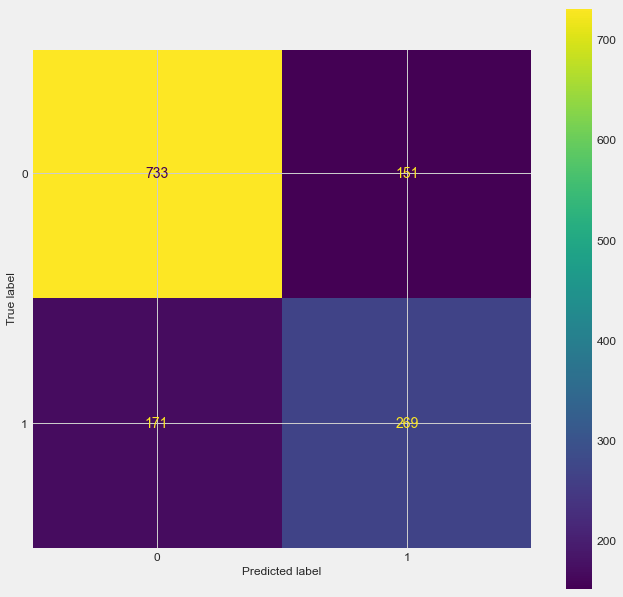

In [25]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5)

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train, y_train)
y_val_pred = pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_val)
preds = np.array(y_val_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

#### KNN

(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       884
           1       0.69      0.52      0.59       440

    accuracy                           0.76      1324
   macro avg       0.74      0.70      0.71      1324
weighted avg       0.75      0.76      0.75      1324



,929,263,936,1286,1190,278,1248,788,564,97,448,494,1112,529,889,1078,642,1192
true,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,0,0,1
pred,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1


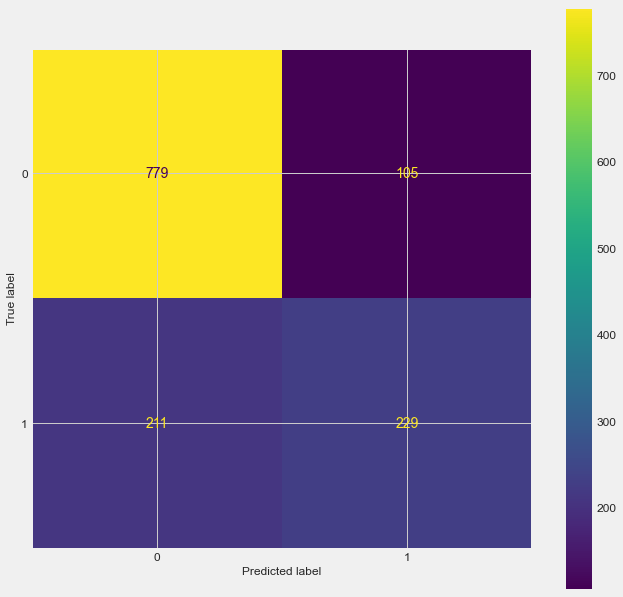

In [26]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(15)

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train, y_train)
y_val_pred = pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_val)
preds = np.array(y_val_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

### Finally, Linear SVM model (LinearSVC) achieved best results and is likely to gerealize better to other data

(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       884
           1       0.65      0.64      0.65       440

    accuracy                           0.77      1324
   macro avg       0.74      0.73      0.74      1324
weighted avg       0.77      0.77      0.77      1324



,400,313,540,33,107,1134,938,34,152,895,211,1140,533,713,483,44,571,547
true,1,0,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0
pred,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0


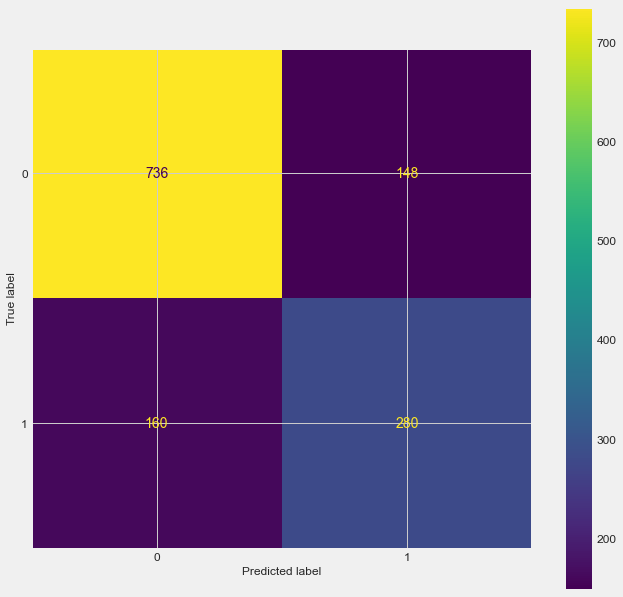

In [27]:
from sklearn.svm import LinearSVC # LinearSVC gave better results than regular SVM (with linear/rbf/poly kernel)

clf = LinearSVC(random_state=42, class_weight='balanced', max_iter=3000) # max_iter=1500
# "class_weight='balanced'": Set the parameter C of class i to [class_weight[i]*C] for SVC. 
# If not given, all classes are supposed to have weight one. The "balanced" mode uses the 
# values of y to automatically adjust weights inversely proportional to class frequencies 
# in the input data as [n_samples / (n_classes * np.bincount(y))].

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

svm_pipe = make_pipeline(preprocessor, clf)

svm_pipe.fit(X_train, y_train)
y_val_pred = svm_pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=svm_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_val)
preds = np.array(y_val_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

In [28]:
# Linear SVC appears to be the best. Ideally, we would verify this by doing CVs and GridSearch for all (top) models!

#### 10-fold cross-validation with macro F1-score as scoring metric (on the entire training set (X, y), see also grid search below)

In [29]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_pipe, X, y, cv=10, scoring='f1_macro')
# 'f1_macro' for binary classification gives f1 for positive class
print(scores)
print('\n')
print(f"Mean {scores.mean()}, Std {scores.std()}")

# returns average macro-f1 score over 10 folds (no control over stratification, etc. -> stratified k-fold = better?)
# consistent scores with small standard deviation indicate that the model is not overfitting on the training data...

[0.70793186 0.73247226 0.74582252 0.73531354 0.73287067 0.7367489
 0.76029786 0.74020754 0.73359405 0.73387388]


Mean 0.7359133071262484, Std 0.012352712496753153


#### SVM GridSearch under 10-fold cross-validation to determine the optimal settings for the “C”, “loss”, and “penalty” parameters

In [30]:
clf.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 3000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

In [31]:
params = [{
    #'columntransformer__tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (1, 4), (1, 6), (2, 7)],
    'linearsvc__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], # strength of the regularization
    'linearsvc__loss': ['squared_hinge', 'hinge'], # hinge = standard; squared_hinge = square of hinge loss
    'linearsvc__penalty': ['l2'] # norm used in the penalization; default = ‘l2’
    # Note: combination of penalty='l1' and (squared_)loss='hinge' is not supported; loss='log' is not supported
    }]

gs = GridSearchCV(svm_pipe, params, n_jobs=-1, cv=10, verbose=1, scoring='f1_macro')
gs.fit(X, y)

print(gs.best_score_)  # top score
print(gs.best_params_) # best param settings -> GridSearch for hyper-parameter tuning SVM model had been chosen

Fitting 10 folds for each of 16 candidates, totalling 160 fits
0.7465915690254672
{'linearsvc__C': 0.1, 'linearsvc__loss': 'squared_hinge', 'linearsvc__penalty': 'l2'}


#### SVM performance on the 10% validation set with grid searched hyper-parameters

(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       884
           1       0.64      0.65      0.64       440

    accuracy                           0.76      1324
   macro avg       0.73      0.73      0.73      1324
weighted avg       0.76      0.76      0.76      1324



,1116,294,15,1122,396,564,1080,871,456,129,357,72,5,1226,721,287,103,208
true,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
pred,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0


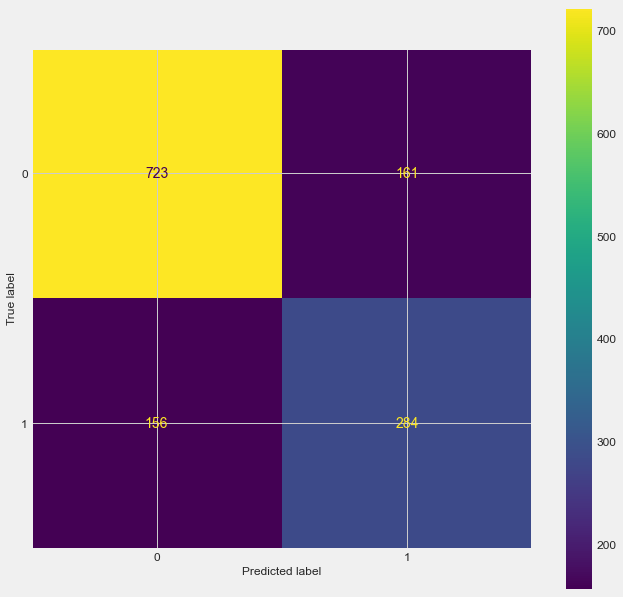

In [32]:
from sklearn.svm import LinearSVC # LinearSVC gave better results than regular SVM (with linear/rbf/poly kernel)

clf = LinearSVC(random_state=42, class_weight='balanced', max_iter=3000, C=0.1) # add optimal C=0.1

# "class_weight='balanced'": Set the parameter C of class i to [class_weight[i]*C] for SVC. 
# If not given, all classes are supposed to have weight one. The "balanced" mode uses the 
# values of y to automatically adjust weights inversely proportional to class frequencies 
# in the input data as [n_samples / (n_classes * np.bincount(y))].

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'), # adding character information did not improve performance; same for CountVectorizer()
    remainder = 'drop')

svm_pipe = make_pipeline(preprocessor, clf)

svm_pipe.fit(X_train, y_train)
y_val_pred = svm_pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=svm_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_val)
preds = np.array(y_val_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

# Note that lowering the "C" parameter from 1.0 to 0.1 actually decreases model performance (see macro F1 & confusion matrix) after using grid-searched hyperparameters. Consequently, we use the previous LinearSVC with C=1.0 instead for out final submissions and all further comparisons:

(11916, 8) (1324, 8) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       884
           1       0.65      0.64      0.65       440

    accuracy                           0.77      1324
   macro avg       0.74      0.73      0.74      1324
weighted avg       0.77      0.77      0.77      1324



,1232,62,842,1315,516,191,515,79,403,227,551,144,605,721,334,931,1292,102
true,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
pred,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1


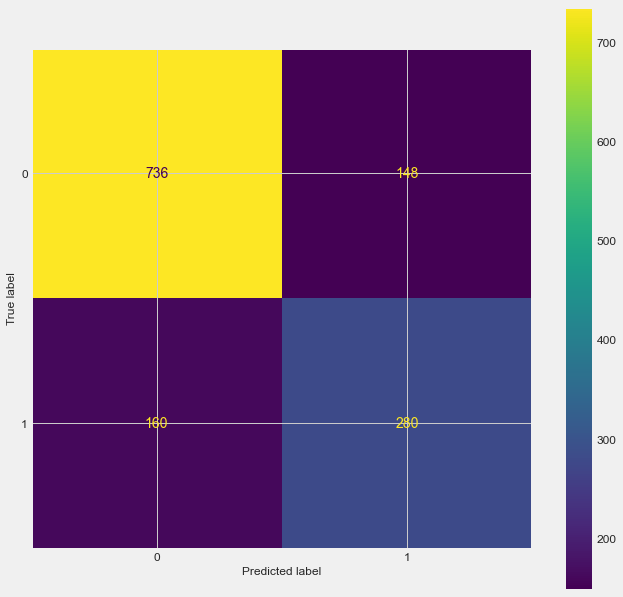

In [33]:
from sklearn.svm import LinearSVC # LinearSVC gave better results than regular SVM (with linear/rbf/poly kernel)

clf = LinearSVC(random_state=42, class_weight='balanced', max_iter=3000) # max_iter=1500
# "class_weight='balanced'": Set the parameter C of class i to [class_weight[i]*C] for SVC. 
# If not given, all classes are supposed to have weight one. The "balanced" mode uses the 
# values of y to automatically adjust weights inversely proportional to class frequencies 
# in the input data as [n_samples / (n_classes * np.bincount(y))].

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (scaler, ['prof', 'prof_prob']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

svm_pipe = make_pipeline(preprocessor, clf)

svm_pipe.fit(X_train, y_train)
y_val_pred = svm_pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=svm_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

truth = np.array(y_val)
preds = np.array(y_val_pred)
comps = pd.DataFrame({'true': truth, 'pred': list(preds)}, columns=['true', 'pred'])
comps.sample(18).T

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       884
           1       0.65      0.64      0.65       440

    accuracy                           0.77      1324
   macro avg       0.74      0.73      0.74      1324
weighted avg       0.77      0.77      0.77      1324



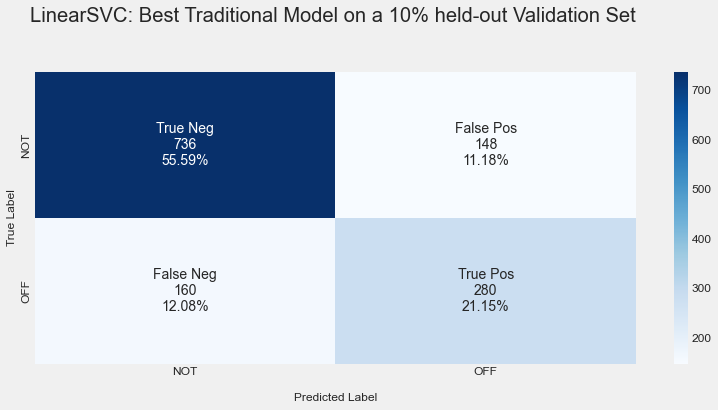

In [34]:
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=svm_pipe.classes_)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('LinearSVC: Best Traditional Model on a 10% held-out Validation Set \n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['NOT','OFF'])
ax.yaxis.set_ticklabels(['NOT','OFF'])

plt.savefig('LinearSVC_on_validation.png', bbox_inches="tight")

## Display the visualization of the Confusion Matrix.
plt.show();

In [35]:
from sklearn.metrics import f1_score
F1 = f1_score(y_val, y_val_pred, average='macro')
F1

0.736063791228706

In [36]:
# Macro F1-score difference between BERT w/o preprocessing (see neural notebook) & traditional SVM model (see above)
0.772 - 0.736

0.03600000000000003

# Predictions on test sets

## test_IN_traditional

In [37]:
data_path = 'test_data/test_IN.csv'
test_IN = pd.read_csv(data_path, delimiter=',', encoding='utf-8')
test_IN.head()

,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,27014,"#ConstitutionDay is revered by Conservatives, ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3,13876,#Watching #Boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...


In [38]:
test_IN.rename({'tweet': 'text'}, axis=1, inplace=True) # rename columns if necessary
test_IN.head()

,id,text
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,27014,"#ConstitutionDay is revered by Conservatives, ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3,13876,#Watching #Boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...


In [39]:
test_IN.shape

(860, 2)

In [40]:
# Check for missing values
test_IN.isnull().sum()

id      0
text    0
dtype: int64

In [41]:
# Check for duplicates
test_IN.duplicated().sum()

0

In [42]:
# Feature extraction > Preprocessing

test_IN['compound'] = [analyzer.polarity_scores(x)['compound'] for x in test_IN['text']]
test_IN['neg'] = [analyzer.polarity_scores(x)['neg'] for x in test_IN['text']]
test_IN['neu'] = [analyzer.polarity_scores(x)['neu'] for x in test_IN['text']]
test_IN['pos'] = [analyzer.polarity_scores(x)['pos'] for x in test_IN['text']]
test_IN.head()

test_IN['prof'] = predict(test_IN['text'])
test_IN['prof_prob'] = predict_prob(test_IN['text'])
test_IN.head()

test_IN['clean'] = test_IN['text'].apply(lambda x: clean(x))
test_IN.head()

,id,text,compound,neg,neu,pos,prof,prof_prob,clean
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,-0.8260,0.288,0.638,0.075,0,0.208122,whoisq wherestheserver dumpnike declasfisa dem...
1,27014,"#ConstitutionDay is revered by Conservatives, ...",-0.1531,0.223,0.532,0.245,0,0.112562,constitutionday revered conservative hated pro...
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,0.0000,0.000,1.000,0.000,0,0.037259,foxnews nra maga potus trump ndamendment rnc u...
3,13876,#Watching #Boomer getting the news that she is...,0.5719,0.000,0.810,0.190,0,0.025649,watching boomer getting news still parole alwa...
4,60133,#NoPasaran: Unity demo to oppose the far-right...,0.0000,0.000,1.000,0.000,0,0.021940,nopasaran unity demo oppose far right london a...


In [43]:
test_IN['label'] = svm_pipe.predict(test_IN)
test_IN_traditional = test_IN[['id', 'label']]
test_IN_traditional['label'] = test_IN_traditional.label.map({0 : 'NOT', 1: 'OFF'}) 
test_IN_traditional.head()

<ipython-input-43-243935cd9fea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_IN_traditional['label'] = test_IN_traditional.label.map({0 : 'NOT', 1: 'OFF'})


,id,label
0,15923,OFF
1,27014,NOT
2,30530,NOT
3,13876,NOT
4,60133,NOT


In [44]:
test_IN_traditional.shape

(860, 2)

In [45]:
test_IN_traditional.label.value_counts()

NOT    653
OFF    207
Name: label, dtype: int64

In [46]:
#test_IN_traditional.to_csv('test_IN_traditional.csv', index=False)

              precision    recall  f1-score   support

         NOT       0.86      0.90      0.88       620
         OFF       0.71      0.61      0.66       240

    accuracy                           0.82       860
   macro avg       0.78      0.76      0.77       860
weighted avg       0.82      0.82      0.82       860



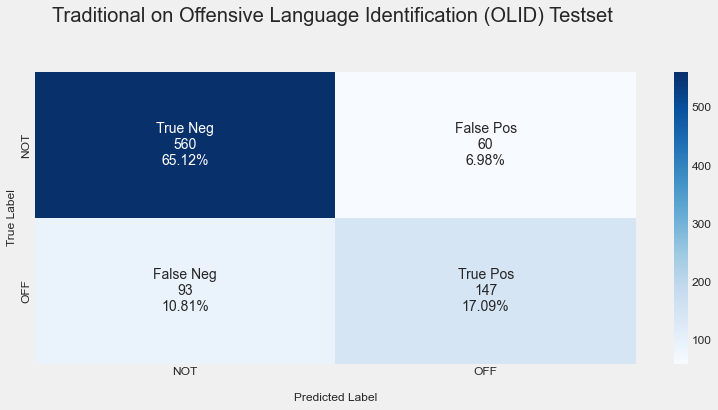

In [47]:
test_SET_gold = pd.read_csv('labels/test_IN_gold.csv', delimiter=',', encoding='utf-8')
test_SET_traditional = pd.read_csv('test_IN_traditional.csv', delimiter=',', encoding='utf-8')

y_val = list(test_SET_gold.label)
y_val_pred = list(test_SET_traditional.label)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Traditional on Offensive Language Identification (OLID) Testset \n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['NOT','OFF'])
ax.yaxis.set_ticklabels(['NOT','OFF'])

plt.savefig('LinearSVC_on_test_OLID.png', bbox_inches="tight")

## Display the visualization of the Confusion Matrix.
plt.show();

## test_OUT1_traditional

In [48]:
data_path = 'test_data/test_OUT1.csv'
test_OUT1 = pd.read_csv(data_path, delimiter=',', encoding='utf-8')
test_OUT1.head()

,id,tweet
0,37,Maybe it could have something to do with the r...
1,127,"Weirdly enough, i think about this fairly freq..."
2,143,Your idea (while posing a real problem with et...
3,146,>it will encourage a part of the people you ba...
4,186,If something like this could make someone supp...


In [49]:
test_OUT1.rename({'tweet': 'text'}, axis=1, inplace=True) # rename columns if necessary
test_OUT1.head()

,id,text
0,37,Maybe it could have something to do with the r...
1,127,"Weirdly enough, i think about this fairly freq..."
2,143,Your idea (while posing a real problem with et...
3,146,>it will encourage a part of the people you ba...
4,186,If something like this could make someone supp...


In [50]:
test_OUT1.shape

(1207, 2)

In [51]:
# Check for missing values
test_OUT1.isnull().sum()

id      0
text    0
dtype: int64

In [52]:
# Check for duplicates
test_OUT1.duplicated().sum()

0

In [53]:
# Feature extraction > Preprocessing

test_OUT1['compound'] = [analyzer.polarity_scores(x)['compound'] for x in test_OUT1['text']]
test_OUT1['neg'] = [analyzer.polarity_scores(x)['neg'] for x in test_OUT1['text']]
test_OUT1['neu'] = [analyzer.polarity_scores(x)['neu'] for x in test_OUT1['text']]
test_OUT1['pos'] = [analyzer.polarity_scores(x)['pos'] for x in test_OUT1['text']]

test_OUT1['prof'] = predict(test_OUT1['text'])
test_OUT1['prof_prob'] = predict_prob(test_OUT1['text'])

test_OUT1['clean'] = test_OUT1['text'].apply(lambda x: clean(x))
test_OUT1.head()

,id,text,compound,neg,neu,pos,prof,prof_prob,clean
0,37,Maybe it could have something to do with the r...,0.4588,0.047,0.819,0.134,0,0.076122,maybe could something recent trend feminist sa...
1,127,"Weirdly enough, i think about this fairly freq...",-0.8218,0.259,0.696,0.045,1,0.906738,weirdly enough think fairly frequently would h...
2,143,Your idea (while posing a real problem with et...,-0.9287,0.226,0.666,0.108,0,0.279921,idea posing real problem ethic work provokes t...
3,146,>it will encourage a part of the people you ba...,-0.9854,0.338,0.551,0.111,0,0.489611,encourage part people ban join terrorist peopl...
4,186,If something like this could make someone supp...,-0.1280,0.238,0.544,0.218,0,0.074159,something like could make someone support isi ...


In [54]:
test_OUT1['label'] = svm_pipe.predict(test_OUT1)
test_OUT1_traditional = test_OUT1[['id', 'label']]
test_OUT1_traditional['label'] = test_OUT1_traditional.label.map({0 : 'NOT', 1: 'OFF'}) 
test_OUT1_traditional.head()

<ipython-input-54-2f5e3f538e67>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_OUT1_traditional['label'] = test_OUT1_traditional.label.map({0 : 'NOT', 1: 'OFF'})


,id,label
0,37,NOT
1,127,OFF
2,143,NOT
3,146,OFF
4,186,OFF


In [55]:
test_OUT1_traditional.shape

(1207, 2)

In [56]:
test_OUT1_traditional.label.value_counts()

NOT    744
OFF    463
Name: label, dtype: int64

In [57]:
#test_OUT1_traditional.to_csv('test_OUT1_traditional.csv', index=False)

              precision    recall  f1-score   support

         NOT       0.68      0.77      0.72       664
         OFF       0.67      0.57      0.61       543

    accuracy                           0.68      1207
   macro avg       0.67      0.67      0.67      1207
weighted avg       0.68      0.68      0.67      1207



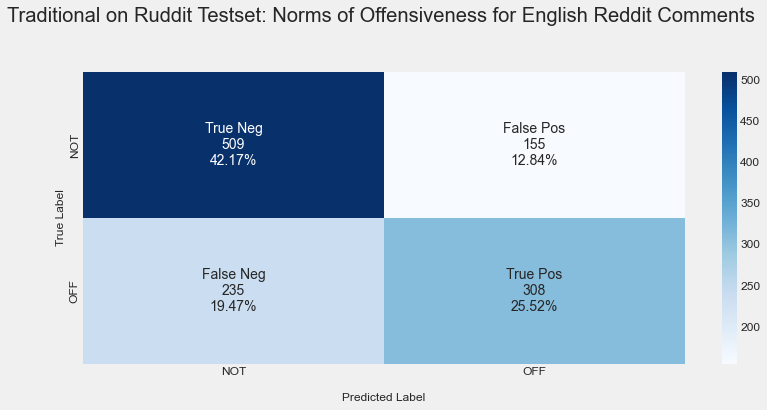

In [58]:
test_SET_gold = pd.read_csv('labels/test_OUT1_gold.csv', delimiter=',', encoding='utf-8')
test_SET_traditional = pd.read_csv('test_OUT1_traditional.csv', delimiter=',', encoding='utf-8')

y_val = list(test_SET_gold.label)
y_val_pred = list(test_SET_traditional.label)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Traditional on Ruddit Testset: Norms of Offensiveness for English Reddit Comments \n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['NOT','OFF'])
ax.yaxis.set_ticklabels(['NOT','OFF'])

plt.savefig('LinearSVC_on_test_Ruddit.png', bbox_inches="tight")

## Display the visualization of the Confusion Matrix.
plt.show();

## test_OUT2_traditional

In [59]:
data_path = 'test_data/test_OUT2.csv'
test_OUT2 = pd.read_csv(data_path, delimiter=',', encoding='utf-8')
test_OUT2.head()

,id,tweet
0,0072b9c3697ab8cc,== Argh == \r\n\r\n Some random idiot deleted ...
1,0081b14d79f54b31,(we hate america and we are going to bomb the ...
2,008eb47c4684d190,""" \r\n\r\n So, on the tenth anniversary of 9/1..."
3,010c2a979fab2e3f,casualt i fucked your mum and i liked it !!ies
4,01680b05bde74236,"""Welcome! \r\n\r\n Hello, , and welcome to Wik..."


In [60]:
test_OUT2.rename({'tweet': 'text'}, axis=1, inplace=True) # rename columns if necessary
test_OUT2.head()

,id,text
0,0072b9c3697ab8cc,== Argh == \r\n\r\n Some random idiot deleted ...
1,0081b14d79f54b31,(we hate america and we are going to bomb the ...
2,008eb47c4684d190,""" \r\n\r\n So, on the tenth anniversary of 9/1..."
3,010c2a979fab2e3f,casualt i fucked your mum and i liked it !!ies
4,01680b05bde74236,"""Welcome! \r\n\r\n Hello, , and welcome to Wik..."


In [61]:
test_OUT2.shape

(1200, 2)

In [62]:
# Check for missing values
test_OUT2.isnull().sum()

id      0
text    0
dtype: int64

In [63]:
# Check for duplicates
test_OUT2.duplicated().sum()

0

In [64]:
# Feature extraction > Preprocessing

test_OUT2['compound'] = [analyzer.polarity_scores(x)['compound'] for x in test_OUT2['text']]
test_OUT2['neg'] = [analyzer.polarity_scores(x)['neg'] for x in test_OUT2['text']]
test_OUT2['neu'] = [analyzer.polarity_scores(x)['neu'] for x in test_OUT2['text']]
test_OUT2['pos'] = [analyzer.polarity_scores(x)['pos'] for x in test_OUT2['text']]

test_OUT2['prof'] = predict(test_OUT2['text'])
test_OUT2['prof_prob'] = predict_prob(test_OUT2['text'])

test_OUT2['clean'] = test_OUT2['text'].apply(lambda x: clean(x))
test_OUT2.head()

,id,text,compound,neg,neu,pos,prof,prof_prob,clean
0,0072b9c3697ab8cc,== Argh == \r\n\r\n Some random idiot deleted ...,-0.5106,0.231,0.769,0.000,1,0.931627,argh random idiot deleted whole japan article
1,0081b14d79f54b31,(we hate america and we are going to bomb the ...,-0.4404,0.266,0.579,0.154,1,0.970093,hate america going bomb shit city queza rain
2,008eb47c4684d190,""" \r\n\r\n So, on the tenth anniversary of 9/1...",-0.9956,0.241,0.727,0.032,1,0.804672,tenth anniversary new york time columnist paul...
3,010c2a979fab2e3f,casualt i fucked your mum and i liked it !!ies,-0.4912,0.362,0.435,0.203,1,0.995155,casualt fucked mum liked y
4,01680b05bde74236,"""Welcome! \r\n\r\n Hello, , and welcome to Wik...",0.9880,0.000,0.727,0.273,0,0.016452,welcome hello welcome wikipedia thank hope lik...


In [65]:
test_OUT2['label'] = svm_pipe.predict(test_OUT2)
test_OUT2_traditional = test_OUT2[['id', 'label']]
test_OUT2_traditional['label'] = test_OUT2_traditional.label.map({0 : 'NOT', 1: 'OFF'}) 
test_OUT2_traditional.head()

<ipython-input-65-330763420975>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_OUT2_traditional['label'] = test_OUT2_traditional.label.map({0 : 'NOT', 1: 'OFF'})


,id,label
0,0072b9c3697ab8cc,OFF
1,0081b14d79f54b31,OFF
2,008eb47c4684d190,OFF
3,010c2a979fab2e3f,OFF
4,01680b05bde74236,NOT


In [66]:
test_OUT2_traditional.shape

(1200, 2)

In [67]:
test_OUT2_traditional.label.value_counts()

OFF    660
NOT    540
Name: label, dtype: int64

In [68]:
#test_OUT2_traditional.to_csv('test_OUT2_traditional.csv', index=False)

              precision    recall  f1-score   support

         NOT       0.94      0.84      0.89       600
         OFF       0.86      0.94      0.90       600

    accuracy                           0.90      1200
   macro avg       0.90      0.90      0.89      1200
weighted avg       0.90      0.90      0.89      1200



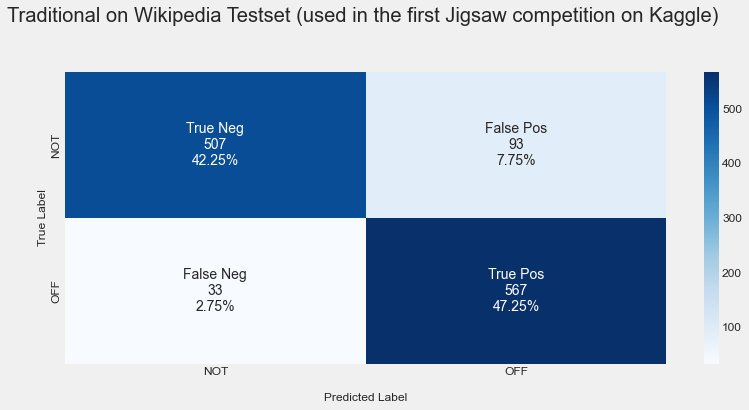

In [69]:
test_SET_gold = pd.read_csv('labels/test_OUT2_gold.csv', delimiter=',', encoding='utf-8')
test_SET_traditional = pd.read_csv('test_OUT2_traditional.csv', delimiter=',', encoding='utf-8')

y_val = list(test_SET_gold.label)
y_val_pred = list(test_SET_traditional.label)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Traditional on Wikipedia Testset (used in the first Jigsaw competition on Kaggle) \n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['NOT','OFF'])
ax.yaxis.set_ticklabels(['NOT','OFF'])

plt.savefig('LinearSVC_on_test_Wikipedia.png', bbox_inches="tight")

## Display the visualization of the Confusion Matrix.
plt.show();

## test_TEXTGAIN

In [70]:
data_path = 'test_data/test_TEXTGAIN.csv'
test_TEXTGAIN = pd.read_csv(data_path, delimiter=',', encoding='utf-8')
test_TEXTGAIN.head()

,id,tweet
0,0,"a few American personality camels, well adjust..."
1,1,@juniormufasa_ how come lukaku flop @ man uu ...
2,2,LUKAKU IS SUCH A NIGGER I HATE THIS APE
3,3,I beg you lot keep that porch monkey coon Shau...
4,4,TRY NOT TO GET HIGH AS THE MONKEY !!! ❌\r\n\r\...


In [71]:
test_TEXTGAIN.rename({'tweet': 'text'}, axis=1, inplace=True) # rename columns if necessary
test_TEXTGAIN.head()

,id,text
0,0,"a few American personality camels, well adjust..."
1,1,@juniormufasa_ how come lukaku flop @ man uu ...
2,2,LUKAKU IS SUCH A NIGGER I HATE THIS APE
3,3,I beg you lot keep that porch monkey coon Shau...
4,4,TRY NOT TO GET HIGH AS THE MONKEY !!! ❌\r\n\r\...


In [72]:
test_TEXTGAIN.shape

(1276, 2)

In [73]:
# Check for missing values
test_TEXTGAIN.isnull().sum()

id      0
text    0
dtype: int64

In [74]:
# Check for duplicates
test_TEXTGAIN.duplicated().sum()

0

In [75]:
# Feature extraction > Preprocessing

test_TEXTGAIN['compound'] = [analyzer.polarity_scores(x)['compound'] for x in test_TEXTGAIN['text']]
test_TEXTGAIN['neg'] = [analyzer.polarity_scores(x)['neg'] for x in test_TEXTGAIN['text']]
test_TEXTGAIN['neu'] = [analyzer.polarity_scores(x)['neu'] for x in test_TEXTGAIN['text']]
test_TEXTGAIN['pos'] = [analyzer.polarity_scores(x)['pos'] for x in test_TEXTGAIN['text']]

test_TEXTGAIN['prof'] = predict(test_TEXTGAIN['text'])
test_TEXTGAIN['prof_prob'] = predict_prob(test_TEXTGAIN['text'])

test_TEXTGAIN['clean'] = test_TEXTGAIN['text'].apply(lambda x: clean(x))
test_TEXTGAIN.head()

,id,text,compound,neg,neu,pos,prof,prof_prob,clean
0,0,"a few American personality camels, well adjust...",0.5994,0.000,0.880,0.12,0,0.132960,american personality camel well adjusted cours...
1,1,@juniormufasa_ how come lukaku flop @ man uu ...,-0.7717,0.401,0.599,0.00,1,0.978385,juniormufasa come lukaku flop man uu de nigger...
2,2,LUKAKU IS SUCH A NIGGER I HATE THIS APE,-0.8402,0.615,0.385,0.00,1,0.979777,lukaku nigger hate ape
3,3,I beg you lot keep that porch monkey coon Shau...,0.3182,0.000,0.850,0.15,1,0.589529,beg lot keep porch monkey coon shaun bailey ti...
4,4,TRY NOT TO GET HIGH AS THE MONKEY !!! ❌\r\n\r\...,0.0000,0.000,1.000,0.00,0,0.167179,try get high monkey cop hoodie k negotiable co...


In [76]:
test_TEXTGAIN['label'] = svm_pipe.predict(test_TEXTGAIN)
test_TEXTGAIN_traditional = test_TEXTGAIN[['id', 'label']]
test_TEXTGAIN_traditional['label'] = test_TEXTGAIN_traditional.label.map({0 : 'NOT', 1: 'OFF'}) 
test_TEXTGAIN_traditional.head()

<ipython-input-76-a28472a63f10>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_TEXTGAIN_traditional['label'] = test_TEXTGAIN_traditional.label.map({0 : 'NOT', 1: 'OFF'})


,id,label
0,0,NOT
1,1,OFF
2,2,OFF
3,3,NOT
4,4,NOT


In [77]:
test_TEXTGAIN_traditional.shape

(1276, 2)

In [78]:
test_TEXTGAIN_traditional.label.value_counts()

NOT    688
OFF    588
Name: label, dtype: int64

In [79]:
#test_TEXTGAIN_traditional.to_csv('test_TEXTGAIN_traditional.csv', index=False)

              precision    recall  f1-score   support

         NOT       0.87      0.55      0.67      1088
         OFF       0.16      0.52      0.25       188

    accuracy                           0.54      1276
   macro avg       0.52      0.53      0.46      1276
weighted avg       0.76      0.54      0.61      1276



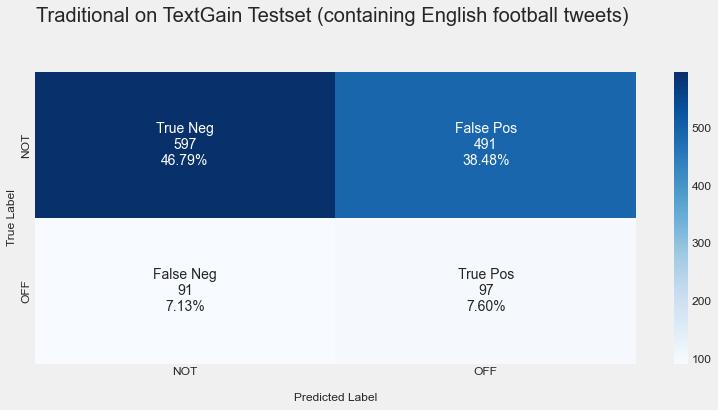

In [80]:
test_SET_gold = pd.read_csv('labels/test_TEXTGAIN_gold.csv', delimiter=',', encoding='utf-8')
test_SET_traditional = pd.read_csv('test_TEXTGAIN_traditional.csv', delimiter=',', encoding='utf-8')

y_val = list(test_SET_gold.label)
y_val_pred = list(test_SET_traditional.label)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Traditional on TextGain Testset (containing English football tweets) \n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['NOT','OFF'])
ax.yaxis.set_ticklabels(['NOT','OFF'])

plt.savefig('LinearSVC_on_test_TextGain.png', bbox_inches="tight")

## Display the visualization of the Confusion Matrix.
plt.show();